# 02 :: Distribution Plots

**Objectives:**
* Plot distributions by Region and Age

In [17]:
# %load common.py
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Commonly used constants.

slides = [
    'B02_D1', 'B02_E1', 'B03_C2', 'B03_D2', 'B04_D1',
    'B04_E1', 'B05_D2', 'B05_E2', 'B06_E1', 'B07_C2',
    'N02_C1', 'N02_D1', 'N03_C2', 'N03_D2', 'N04_D1',
    'N04_E1', 'N05_C2', 'N05_D2', 'N06_D2', 'N07_C1']

GT = 'GT'
YEN = 'AB1_StdDev_Yen'
REGION = 'Region_predict'
ASTROCYTE = 'astrocyte'
NEURON = 'neuron'
INTERNEURON = 'interneuron'
AGE = 'age'
DAYS = 'age_days'
MONTHS = 'age_months'
AGE_GT ='age_GT'
SAMPLE_ID = 'sampleID'
SPOT_UID = 'spot_UID'
SLIDE_ID = 'slide_ID'

# The merged data file in Parquet format.

parquet = '/media/tmo/data/work/datasets/02_ST/parquet/'
st_full = parquet + 'st_full'

def read_full(path=st_full):
    return pd.read_parquet(st_full)

def enrich(full):
    # Add age column (young, old)
    full[AGE] = np.where(full[MONTHS] < 10, 'young', 'old')
    
    # Add combined column age_GT.
    full[AGE_GT] = full[[AGE, GT]].apply(lambda x: '_'.join(x), axis=1)
    
    # parse slide ID
    full['slide_ID'] = full[SPOT_UID].apply(lambda x: str(x).split('__')[0])
    
    return full

def read_enriched(path=st_full):
    return enrich(read_full(path))
    
# TODO
# * add 'coarse_region' that joins regions with <500 entries in them into one region OTHER

In [18]:
# SLIDE_META_COLUMNS = ['Sample id', 'GenotypeShort', 'Age (day)', 'Age (month)']
SLIDE_META_COLUMNS = ['sampleID', 'GT', 'age_days', 'age_months']

In [19]:
SPOT_META_COLUMNS = ['sampleID', 'AB1_StdDev_Yen', 'Region_predict',
                     'microglia', 'neuron', 'astrocyte', 'oligodendrocyte', 'endothelial', 'interneuron']

In [20]:
CELL_TYPES = SPOT_META_COLUMNS[3:]
CELL_TYPES

['microglia',
 'neuron',
 'astrocyte',
 'oligodendrocyte',
 'endothelial',
 'interneuron']

---

# Analysis

In [21]:
%%time
full = read_enriched()

CPU times: user 8.43 s, sys: 11 s, total: 19.5 s
Wall time: 8.82 s


In [22]:
full.shape

(10327, 46760)

In [23]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10327 entries, 0 to 477
Columns: 46760 entries, spot_UID to slide_ID
dtypes: float32(46454), float64(234), int64(65), object(7)
memory usage: 1.8+ GB


In [24]:
full['age_GT'].value_counts()

young_WT    2814
old_KI      2516
old_WT      2504
young_KI    2493
Name: age_GT, dtype: int64

In [25]:
meta_df = full[SLIDE_META_COLUMNS + SPOT_META_COLUMNS + ['age', 'age_GT']]
meta_df.head()

,sampleID,GT,age_days,age_months,sampleID,AB1_StdDev_Yen,Region_predict,microglia,neuron,astrocyte,oligodendrocyte,endothelial,interneuron,age,age_GT
0,B02_D1,WT,107,4,B02_D1,0.0,AT_OLF,0.119315,0.032347,0.084108,-0.071774,0.015555,-0.098903,young,young_WT
1,B02_D1,WT,107,4,B02_D1,0.0,AT_HY,0.075579,0.132762,0.076381,-0.016686,0.091661,0.286832,young,young_WT
2,B02_D1,WT,107,4,B02_D1,0.0,AT_HY,0.066301,-0.015303,0.186733,-0.021227,0.063068,0.085310,young,young_WT
3,B02_D1,WT,107,4,B02_D1,0.0,unknown,0.183595,0.060572,0.191472,0.075224,0.231584,0.311879,young,young_WT
4,B02_D1,WT,107,4,B02_D1,0.0,AT_OLF,-0.050931,0.038941,0.116606,-0.091150,0.040463,-0.001418,young,young_WT


In [26]:
full.columns[-310:]

Index(['n-R5s96', 'n-R5s97', 'n-R5s98', 'n-TSaga9', 'n-TStga1', 'spot_ID',
       'spot_X', 'spot_Y', 'AB1_Mean_Yen', 'AB1_Median_Yen',
       ...
       'astrocyte', 'oligodendrocyte', 'endothelial', 'interneuron', 'GT',
       'age_days', 'age_months', 'age', 'age_GT', 'slide_ID'],
      dtype='object', length=310)

## **AB1 StdDev Yen**

* only KI samples have a plaque vicinity > 0

In [27]:
meta_df[meta_df[YEN] > 0.0]['GT'].value_counts()

KI    5009
Name: GT, dtype: int64

In [28]:
meta_df['GT'].value_counts()

WT    5318
KI    5009
Name: GT, dtype: int64

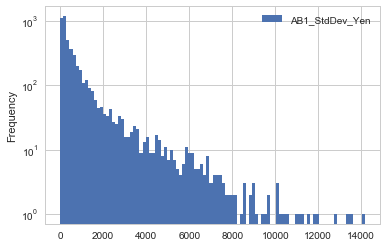

In [29]:
meta_df[meta_df[YEN] > 0.0][[YEN]].plot.hist(bins=100, 
                                             log=True)
plt.show()

In [30]:
meta_df['age_months'].value_counts()

4     4292
18    4085
6     1015
12     935
Name: age_months, dtype: int64

In [31]:
regions = meta_df[REGION].unique()
regions.sort()
regions

array(['AT_AUD', 'AT_CNU', 'AT_CTXsp', 'AT_ECT', 'AT_ENTI', 'AT_FB',
       'AT_FB_HY', 'AT_FB_TH', 'AT_HPd_CA1_slm', 'AT_HPd_CA1_so',
       'AT_HPd_CA1_sr', 'AT_HPd_CA2_slm', 'AT_HPd_CA2_so', 'AT_HPd_CA2_sr',
       'AT_HPd_CA3_slm', 'AT_HPd_CA3_slu', 'AT_HPd_CA3_so',
       'AT_HPd_CA3_sr', 'AT_HPd_DG_mo', 'AT_HPd_DG_po', 'AT_HPs_CA1_sp',
       'AT_HPs_CA2_sp', 'AT_HPs_CA3_sp', 'AT_HPs_DG_sp', 'AT_HY', 'AT_MB',
       'AT_OLF', 'AT_PERI', 'AT_PTL', 'AT_RSP', 'AT_SSp', 'AT_TE', 'AT_TH',
       'AT_VL', 'unknown'], dtype=object)

In [40]:
slide_IDs = full['slide_ID'].unique()
slide_IDs.sort()
slide_IDs

array(['B02_D1', 'B02_E1', 'B03_C2', 'B03_D2', 'B04_D1', 'B04_E1',
       'B05_D2', 'B05_E2', 'B06_E1', 'B07_C2', 'N02_C1', 'N02_D1',
       'N03_C2', 'N03_D2', 'N04_D1', 'N04_E1', 'N05_C2', 'N05_D2',
       'N06_D2', 'N07_C1'], dtype=object)

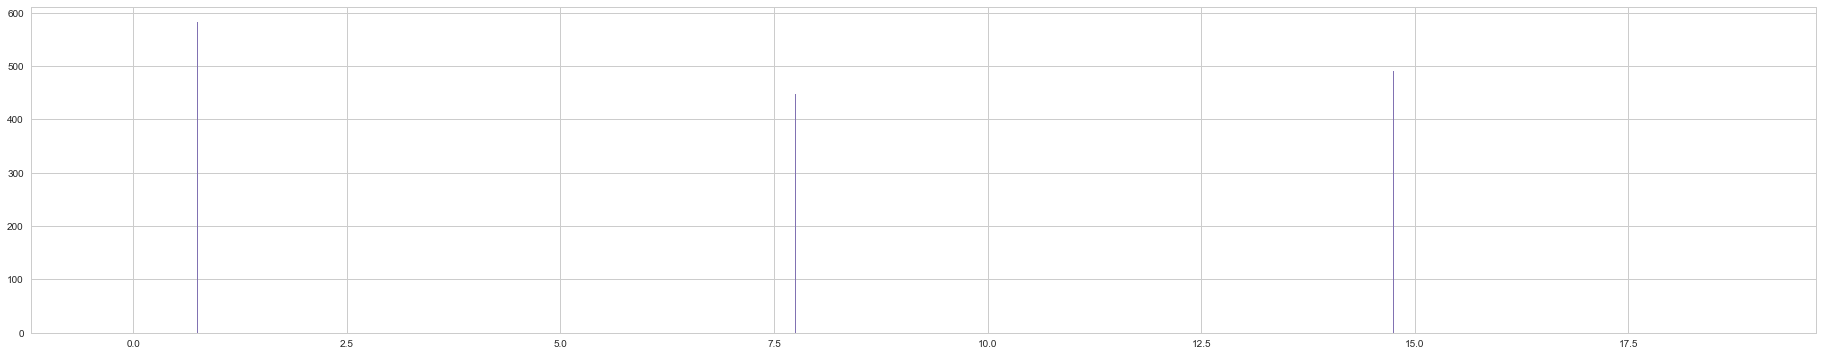

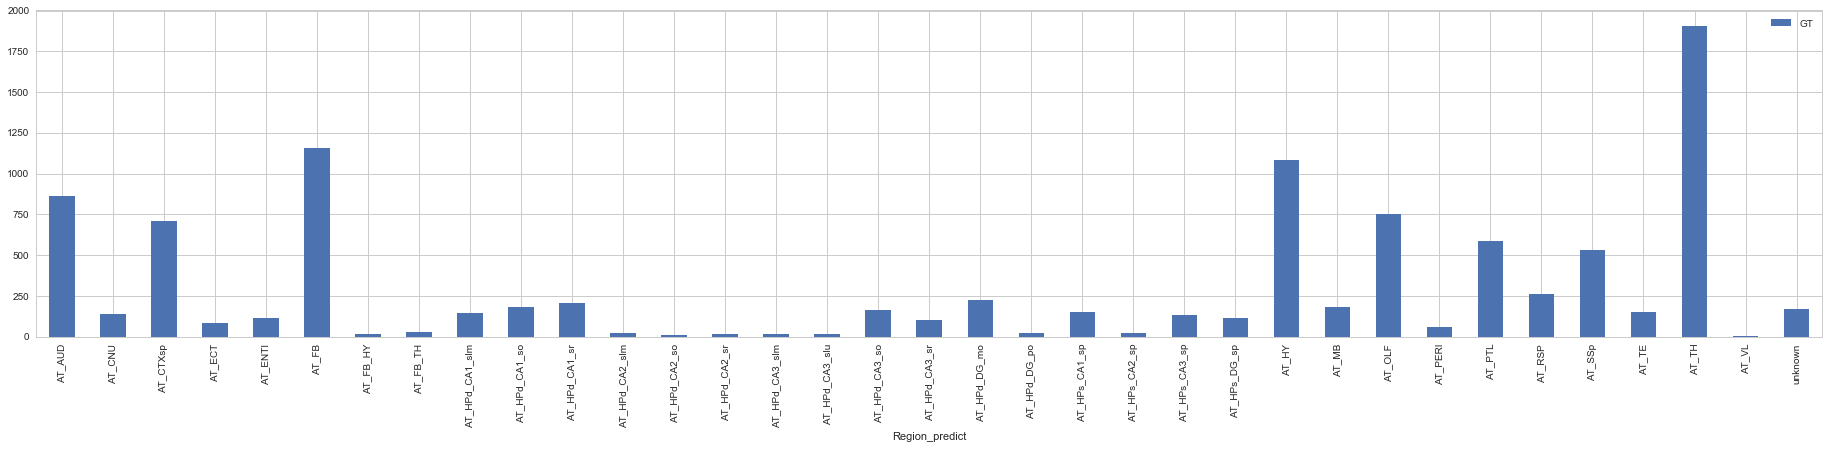

In [41]:
meta_df[[REGION, GT]].groupby(REGION).count().plot(kind='bar', figsize=(32,6))
plt.show()

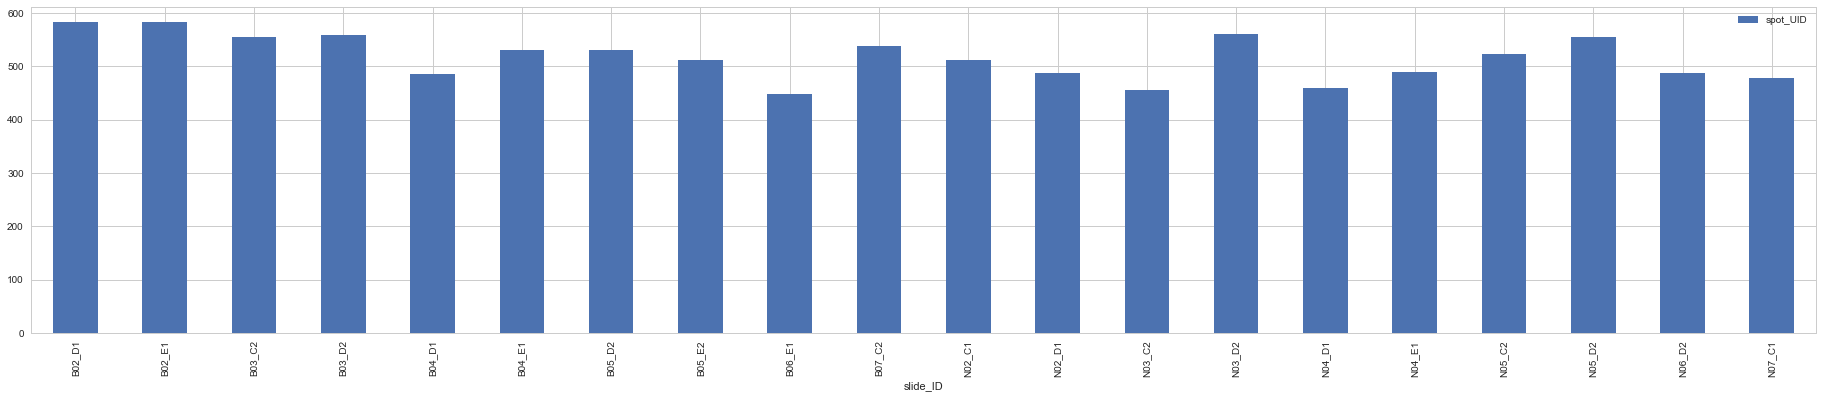

In [45]:
full[['slide_ID', 'spot_UID']].groupby('slide_ID').count().plot(kind='bar', figsize=(32, 6))
plt.show()

## **Plaque pixel intensity StdDev Yen**

### **By age (months)**

fig, ax = plt.subplots(figsize=(10, 6))

# ax.set(yscale="log")
data = meta_df[(meta_df['GT'] == 'KI')][[YEN, MONTHS, AGE]]
sns.boxplot(data=data, x=AGE, y=YEN, palette="Set1", dodge=True)

plt.show()

### **AB1 (StdDev Yen) By Region / Age in KI**

* https://stackoverflow.com/questions/40514921/ordering-boxplot-x-axis-in-seaborn

* observation:
    
    * wide: 'N02_C1', 'N02_D1', 'N03_C2', 'N03_D2', 'N07_C1' `-->` **Young**
    * skinny: 'N04_D1', 'N04_E1', 'N05_C2', 'N05_D2', 'N06_D2' `-->` **Old**

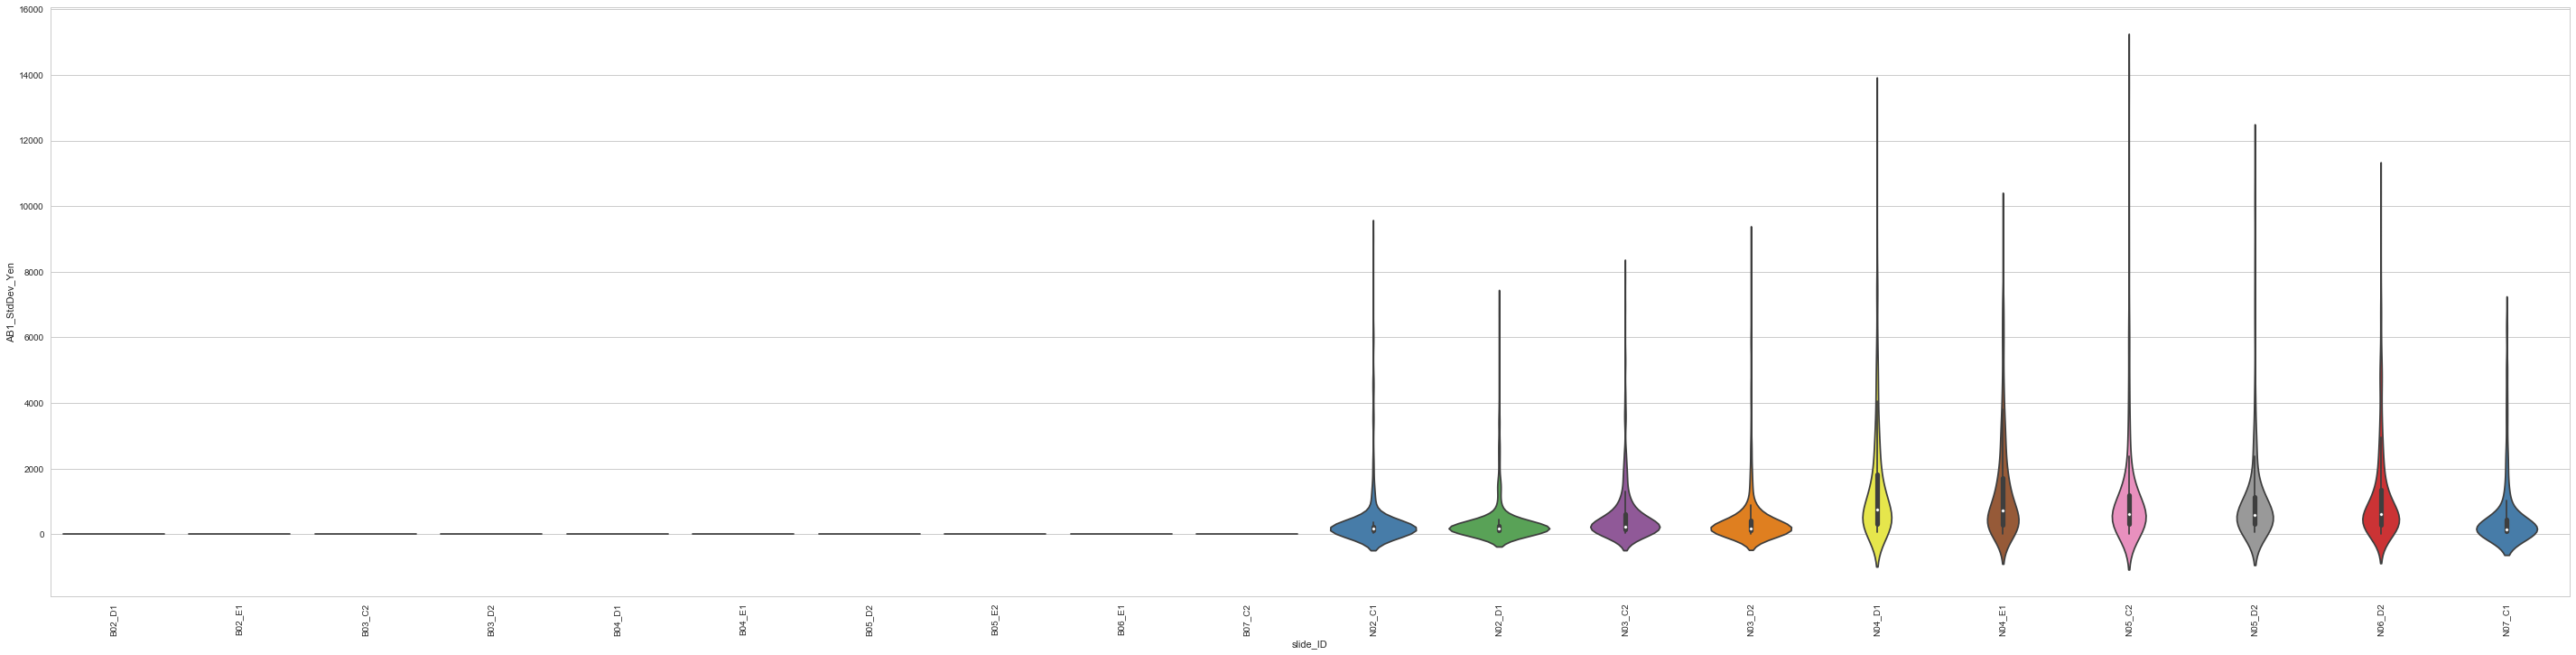

In [57]:
fig, ax = plt.subplots(figsize=(50, 12))

data = full[[YEN, 'slide_ID']]
g = sns.violinplot(data=data, x='slide_ID', y=YEN, palette="Set1", order=slides)
g.set_xticklabels(rotation=90, labels=slides)

plt.show()

In [59]:
['Olfr1326-ps1', 'Cadm2', 'March8', 'Tmsb15l', 'Skp1a', 'Gm42706',
       'Gm42472', 'Metrnl', 'Mfap1b', 'Depdc7', 'Gm17232', 'Vps33a',
       '4921513D11Rik', 'Gm20426', 'Gm29112', '1700015O11Rik',
       'RP23-386F15.2', 'Gm11986', 'Adrb2', 'Tmem128', 'Gm18410',
       'Gm44673', '2210013O21Rik', 'Fnip2', 'RP23-193A14.2',
       'C630050I24Rik', 'Gm19088', 'Gm29438', 'Ube2r2', 'Rfng', 'Olfr350',
       'Snrpb', 'RP23-287L13.6', 'Psat1', 'Ctrl', 'Gm44565', 'Enpp6',
       'Mkl2', 'Triml1', 'Igkv1-115', 'Tspan2os', 'Gm22938', 'Gm36950',
       '4930563E22Rik', 'Gm18194', 'Gm24521', 'Necab3', 'B230369F24Rik',
       'Defb40', 'Gm6274']

['Olfr1326-ps1',
 'Cadm2',
 'March8',
 'Tmsb15l',
 'Skp1a',
 'Gm42706',
 'Gm42472',
 'Metrnl',
 'Mfap1b',
 'Depdc7',
 'Gm17232',
 'Vps33a',
 '4921513D11Rik',
 'Gm20426',
 'Gm29112',
 '1700015O11Rik',
 'RP23-386F15.2',
 'Gm11986',
 'Adrb2',
 'Tmem128',
 'Gm18410',
 'Gm44673',
 '2210013O21Rik',
 'Fnip2',
 'RP23-193A14.2',
 'C630050I24Rik',
 'Gm19088',
 'Gm29438',
 'Ube2r2',
 'Rfng',
 'Olfr350',
 'Snrpb',
 'RP23-287L13.6',
 'Psat1',
 'Ctrl',
 'Gm44565',
 'Enpp6',
 'Mkl2',
 'Triml1',
 'Igkv1-115',
 'Tspan2os',
 'Gm22938',
 'Gm36950',
 '4930563E22Rik',
 'Gm18194',
 'Gm24521',
 'Necab3',
 'B230369F24Rik',
 'Defb40',
 'Gm6274']

In [69]:
march8 = full[['slide_ID', 'March8']].copy()

In [74]:
march8_mins = march8.groupby('slide_ID').min().reset_index()

In [80]:
march8_merged.head()

,slide_ID,March8_x,March8_y,corrected
0,B02_D1,-1.403594,-1.403594,0.000000
1,B02_D1,-0.001068,-1.403594,1.402526
2,B02_D1,0.076412,-1.403594,1.480006
3,B02_D1,-0.111444,-1.403594,1.292150
4,B02_D1,-0.027554,-1.403594,1.376040


In [77]:
march8_merged = march8.merge(march8_mins, how='left', on='slide_ID')

In [79]:
march8_merged['corrected'] = march8_merged['March8_x'] - march8_merged['March8_y']

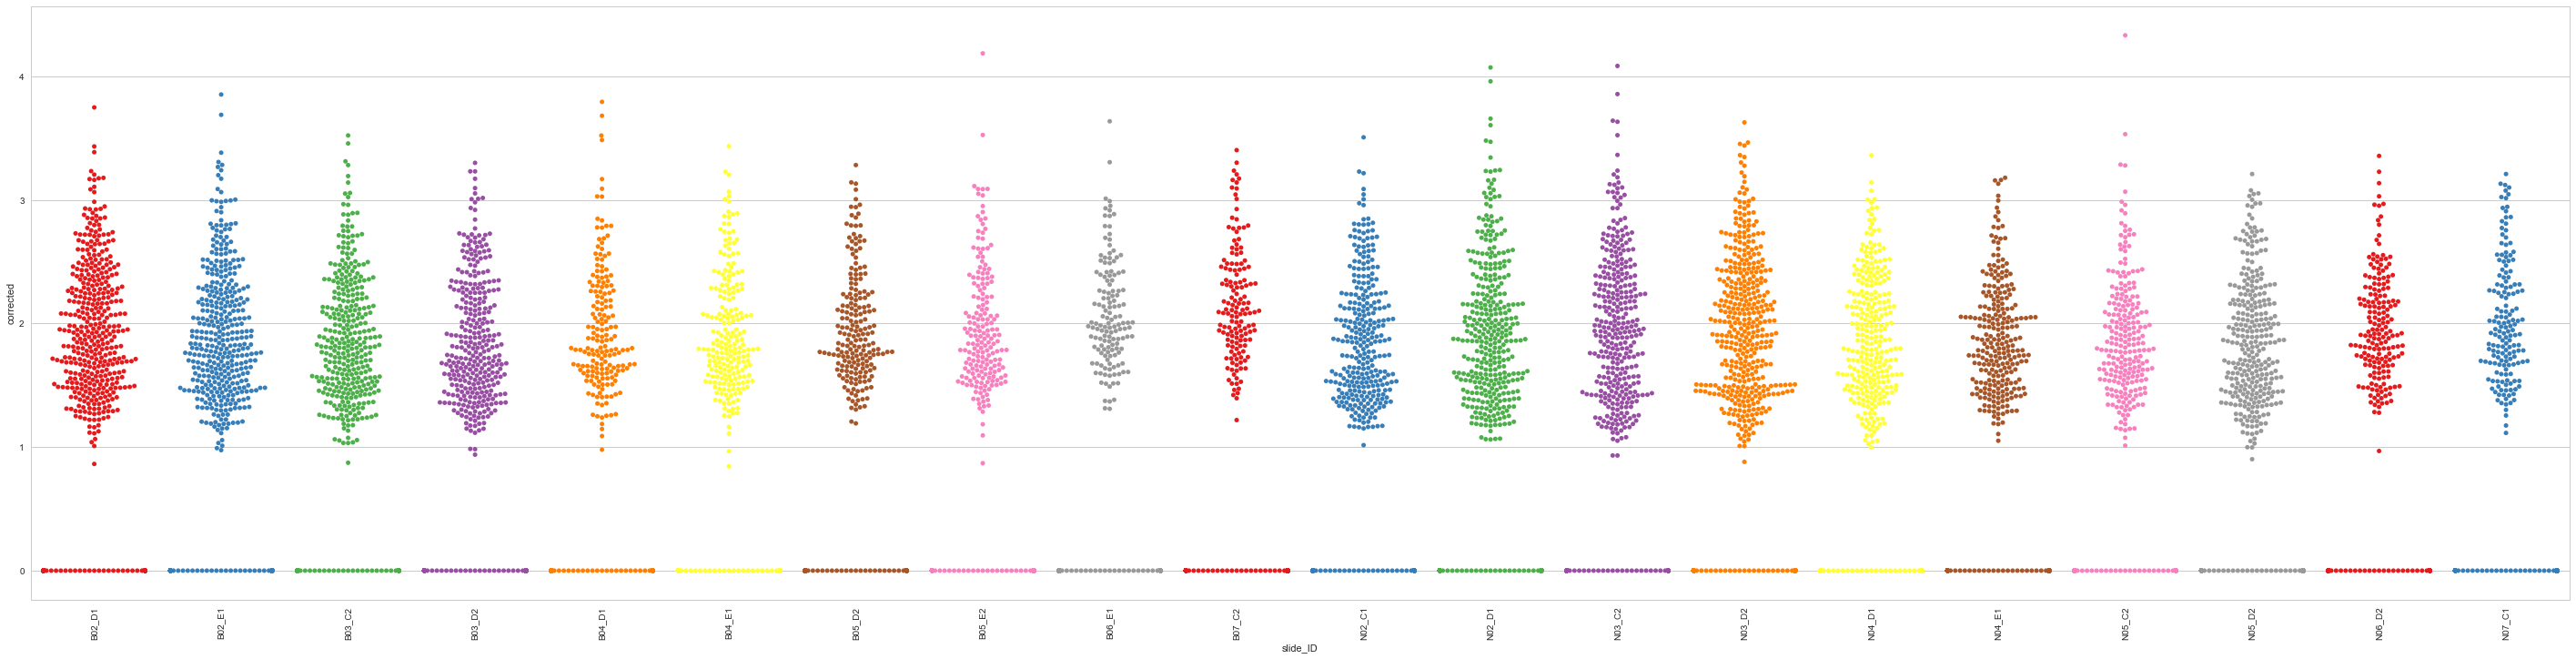

In [81]:
fig, ax = plt.subplots(figsize=(50, 12))

gene = 'March8'

data = march8_merged[['slide_ID', 'corrected']]
g = sns.swarmplot(data=data, x='slide_ID', y='corrected', palette="Set1", order=slides)
g.set_xticklabels(rotation=90, labels=slides)

plt.show()

## Why subtract the mean???
* matrix sparsity killed
* zeros become a discriminating feature cfr. grouping structure inference

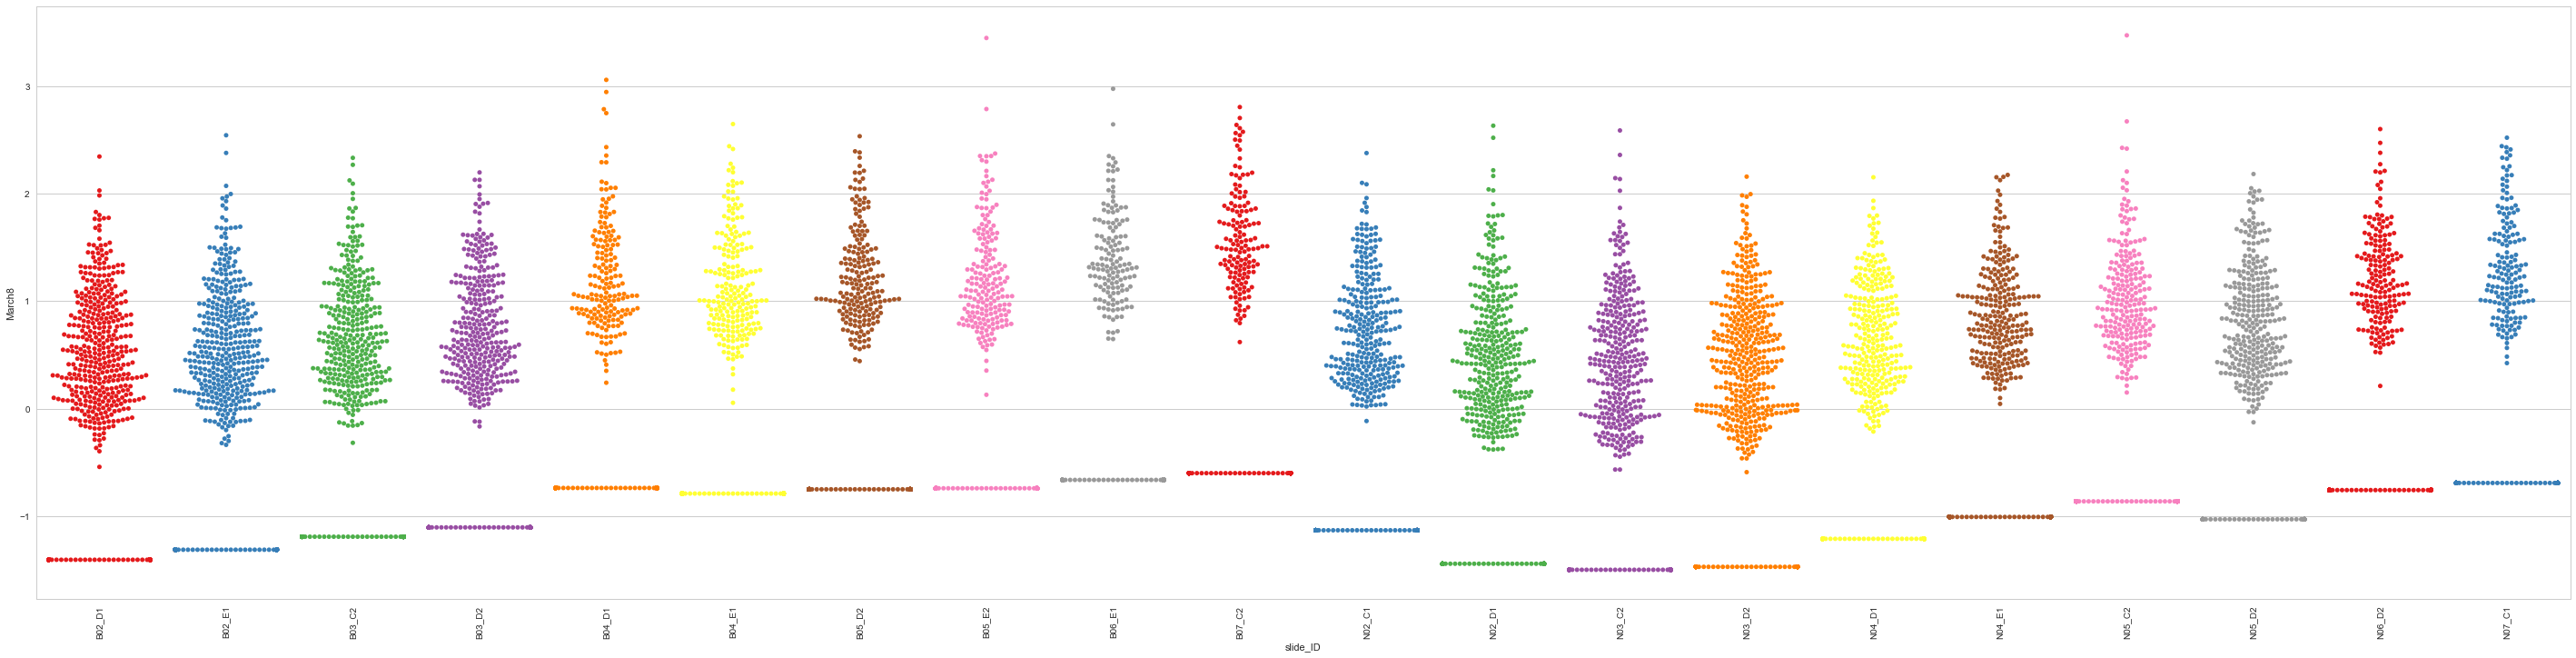

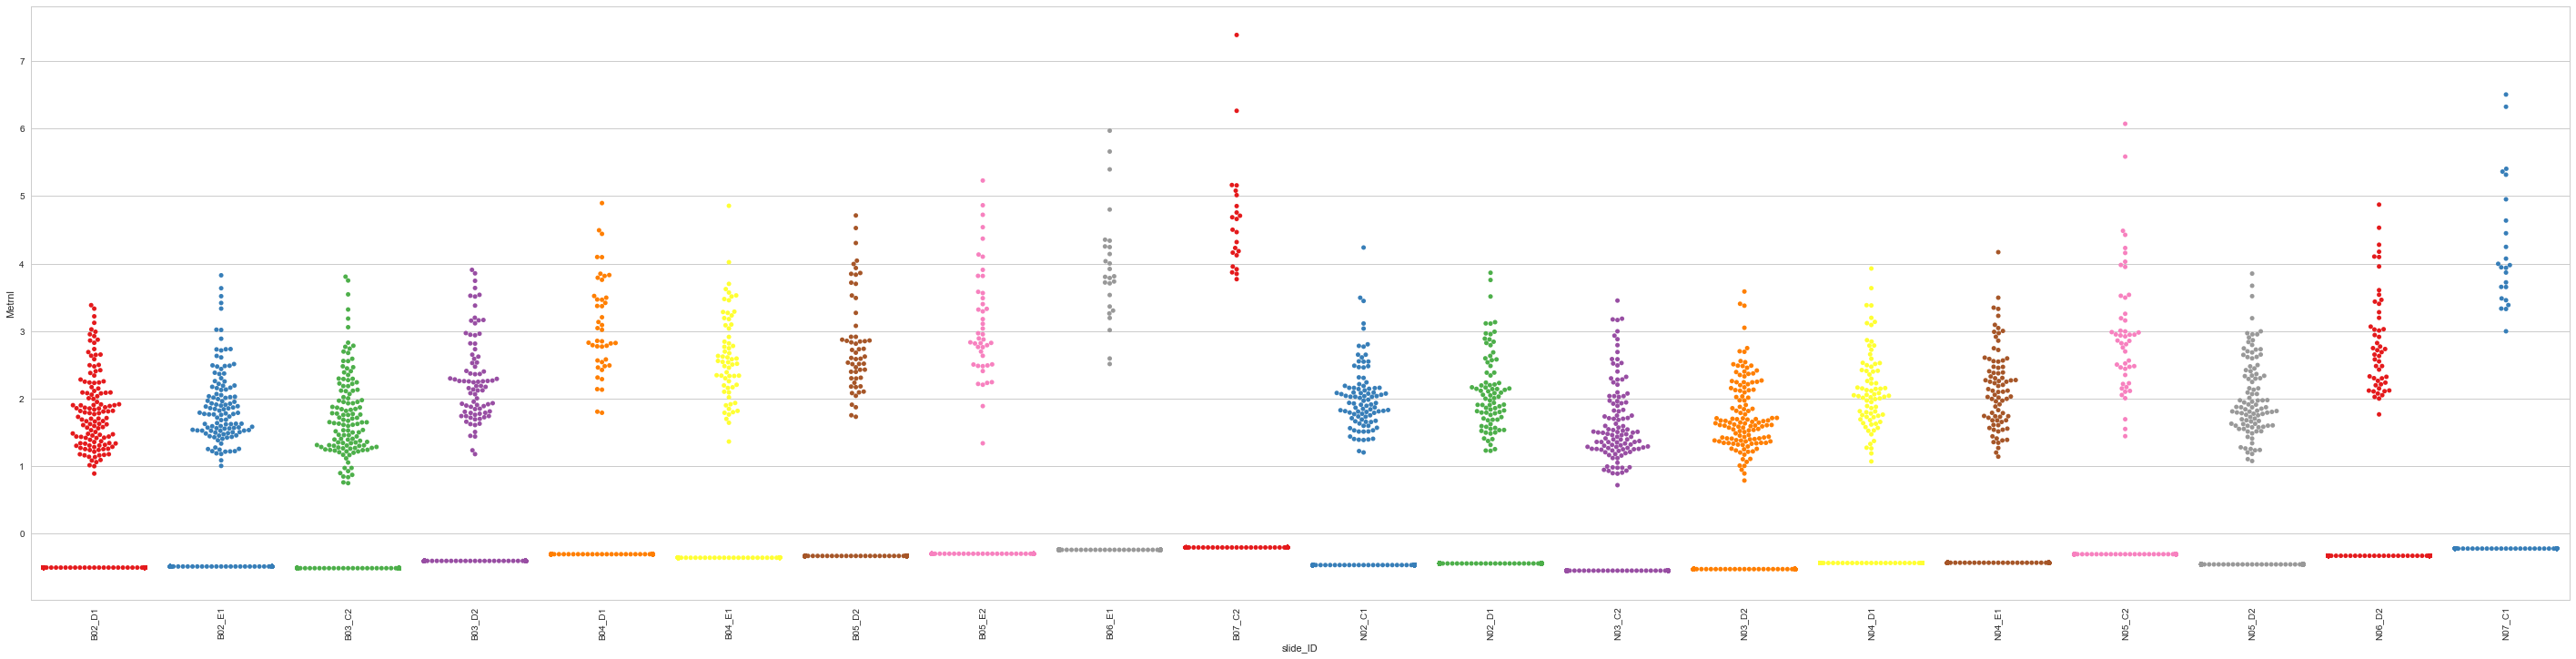

In [65]:
fig, ax = plt.subplots(figsize=(50, 12))

gene = 'Metrnl'

data = full[[gene, 'slide_ID']]
g = sns.swarmplot(data=data, x='slide_ID', y=gene, palette="Set1", order=slides)
g.set_xticklabels(rotation=90, labels=slides)

plt.show()

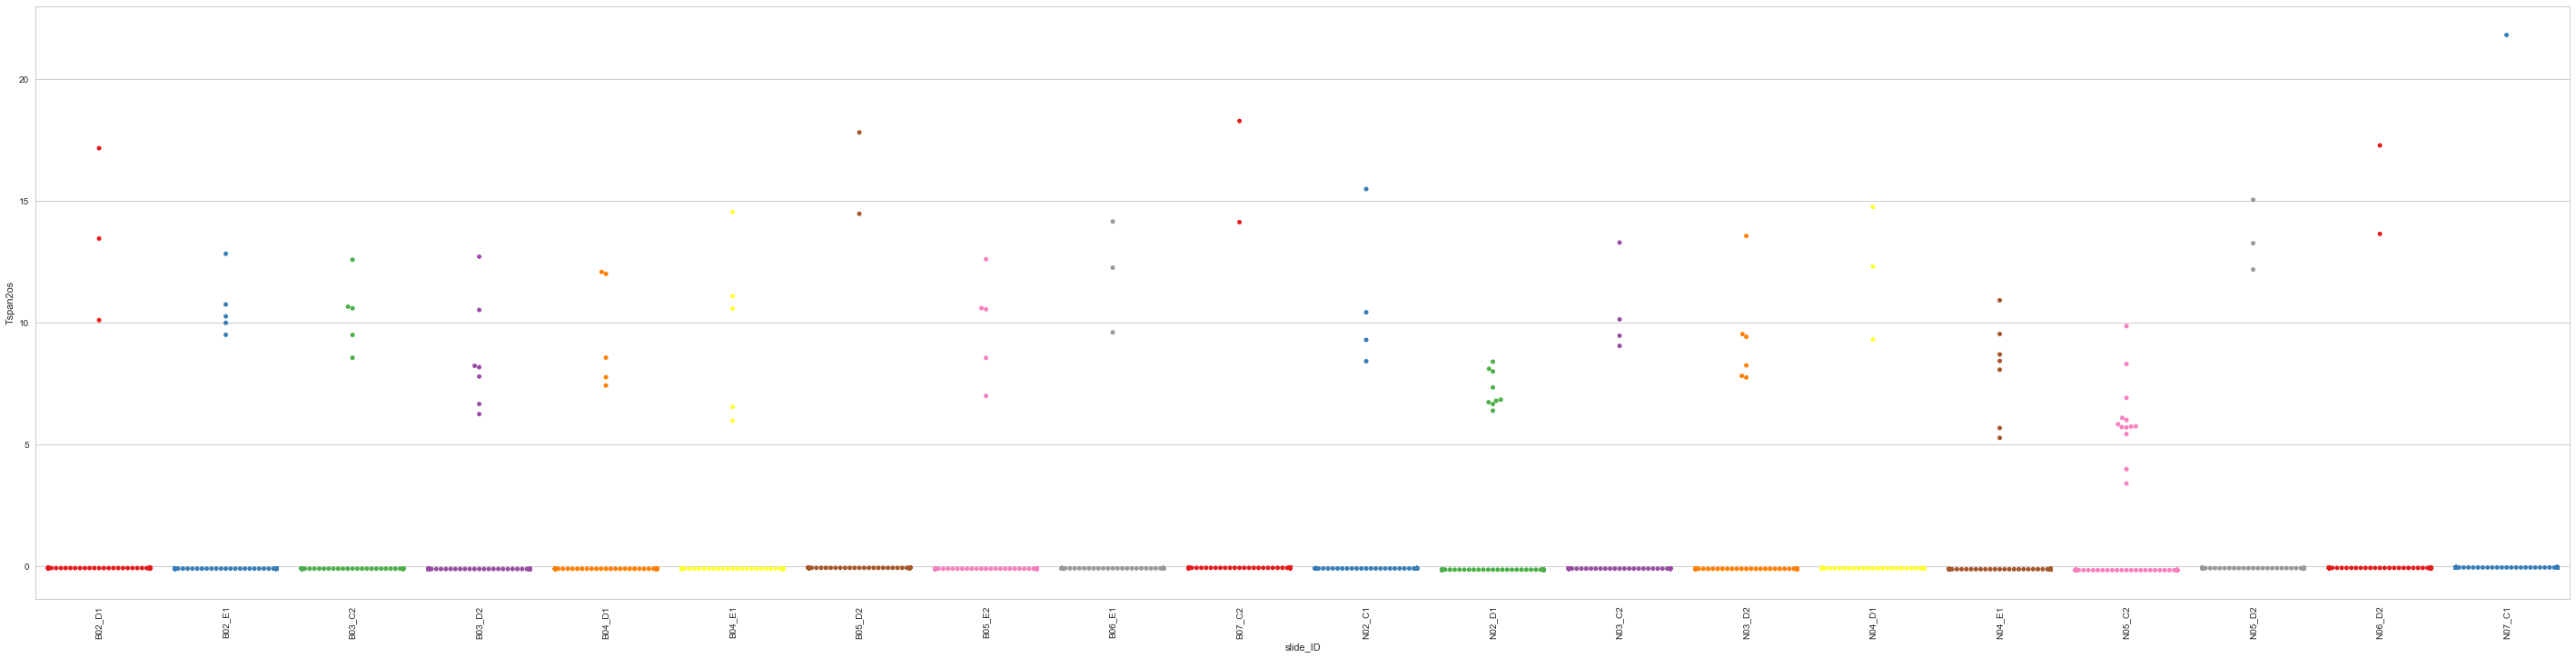

In [64]:
fig, ax = plt.subplots(figsize=(50, 12))

gene = 'Tspan2os'

data = full[[gene, 'slide_ID']]
g = sns.swarmplot(data=data, x='slide_ID', y=gene, palette="Set1", order=slides)
g.set_xticklabels(rotation=90, labels=slides)

plt.show()

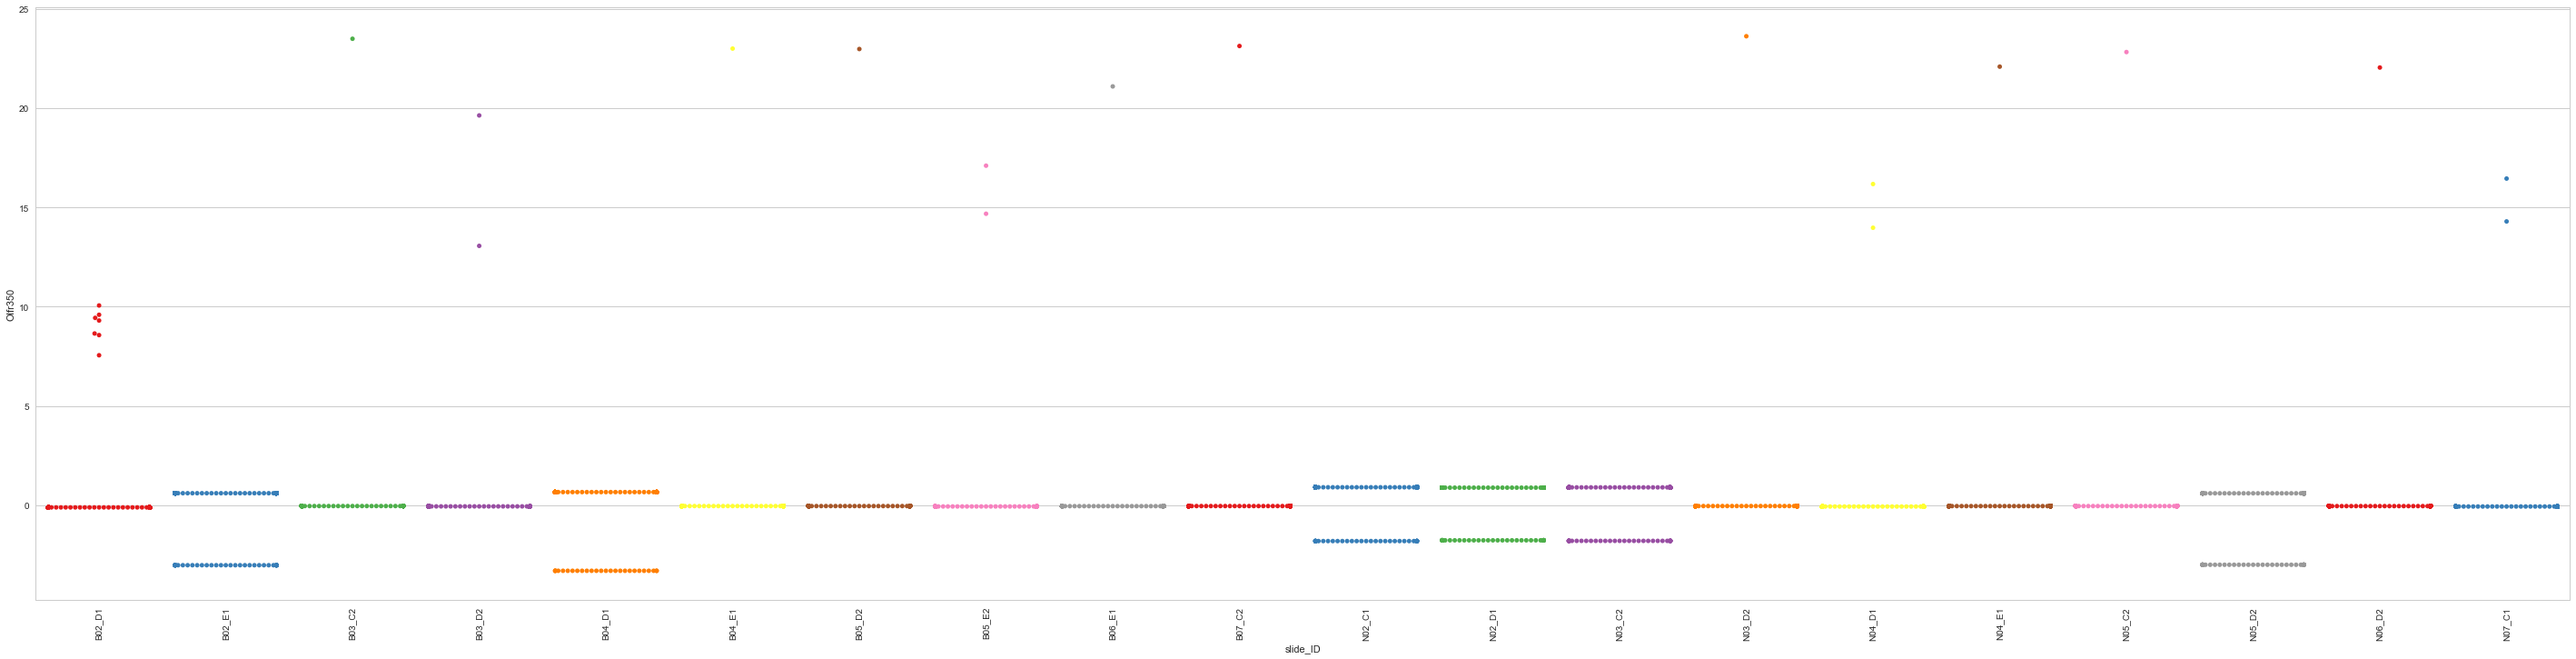

In [61]:
fig, ax = plt.subplots(figsize=(50, 12))

gene = 'Olfr350'

data = full[[gene, 'slide_ID']]
g = sns.swarmplot(data=data, x='slide_ID', y=gene, palette="Set1", order=slides)
g.set_xticklabels(rotation=90, labels=slides)

plt.show()

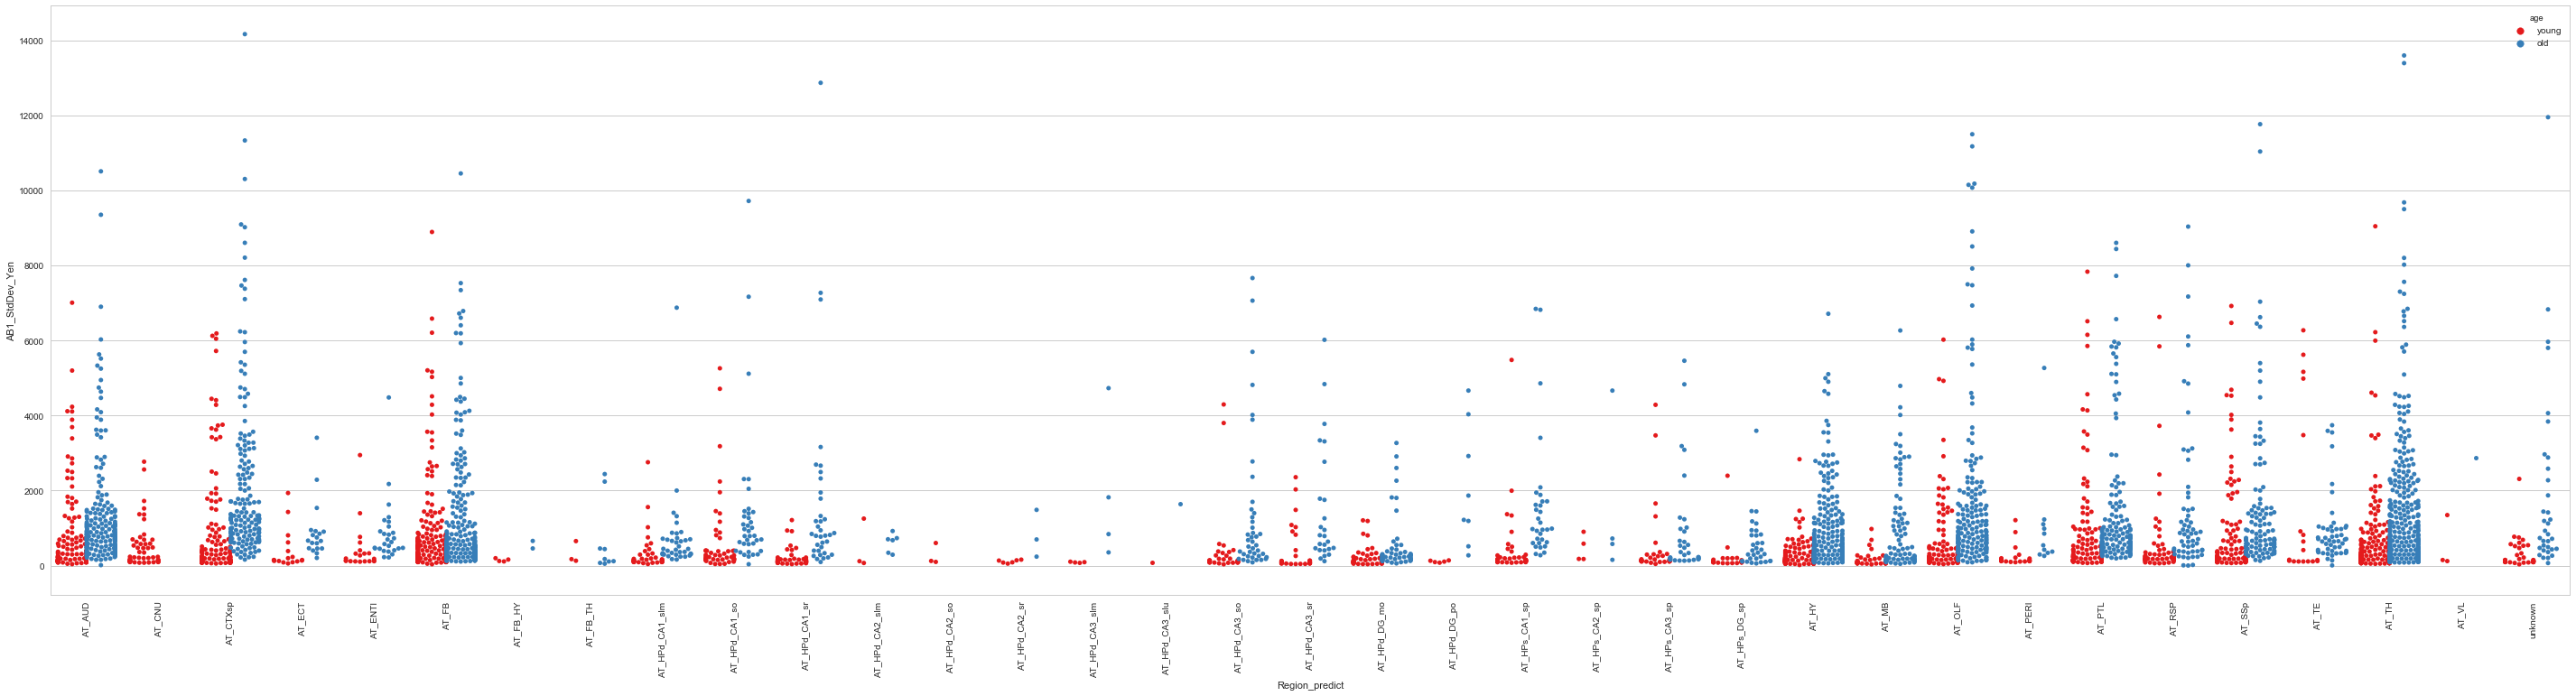

In [25]:
fig, ax = plt.subplots(figsize=(50, 12))

#data = meta_df[(meta_df['GT'] == 'KI') & (meta_df[YEN] < 4000)][[YEN, MONTHS, REGION, AGE]]
data = meta_df[(meta_df['GT'] == 'KI')][[YEN, MONTHS, REGION, AGE]]
g = sns.swarmplot(data=data, x=REGION, y=YEN, hue=AGE, palette="Set1", order=regions, dodge=True)
g.set_xticklabels(rotation=90, labels=regions)

plt.show()

In [26]:
data.describe()

,AB1_StdDev_Yen,age_months
count,5009.000000,5009.000000
mean,881.651610,10.638451
std,1444.236775,6.473870
min,3.499769,4.000000
25%,154.308193,4.000000
50%,329.837907,12.000000
75%,903.144838,18.000000
max,14161.168653,18.000000


## Cell Type distributions by Age and Genotype

In [53]:
def plot_dist_by_age_GT_swarm(meta_df, cell_type):
    fig, ax = plt.subplots(figsize=(100, 8))
    
    data = meta_df[[cell_type, REGION, AGE_GT]]
    g = sns.swarmplot(data=data, x=REGION, y=cell_type, hue=AGE_GT, palette="Set1", order=regions, dodge=True)
    g.set_xticklabels(rotation=90, labels=regions)
    
    plt.show()

In [54]:
def plot_dist_by_age_GT_box(meta_df, cell_type):
    fig, ax = plt.subplots(figsize=(100, 8))
    
    data = meta_df[[cell_type, REGION, AGE_GT]]
    g = sns.boxplot(data=data, x=REGION, y=cell_type, hue=AGE_GT, palette="Set1", order=regions, dodge=True)
    g.set_xticklabels(rotation=90, labels=regions)
    
    plt.show()

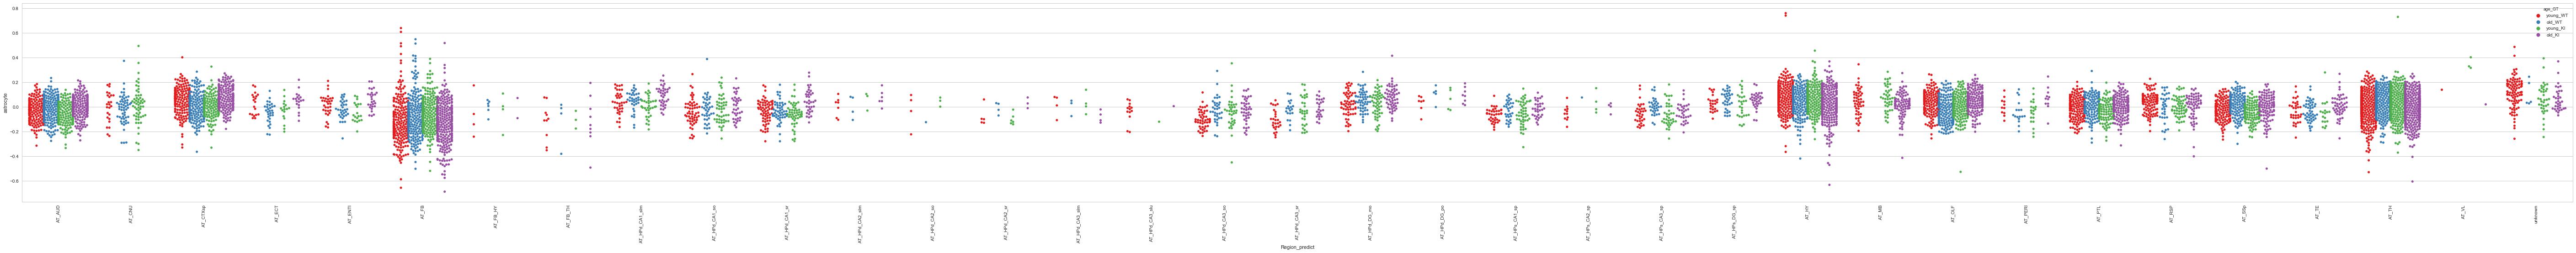

In [55]:
plot_dist_by_age_GT_swarm(meta_df, ASTROCYTE)

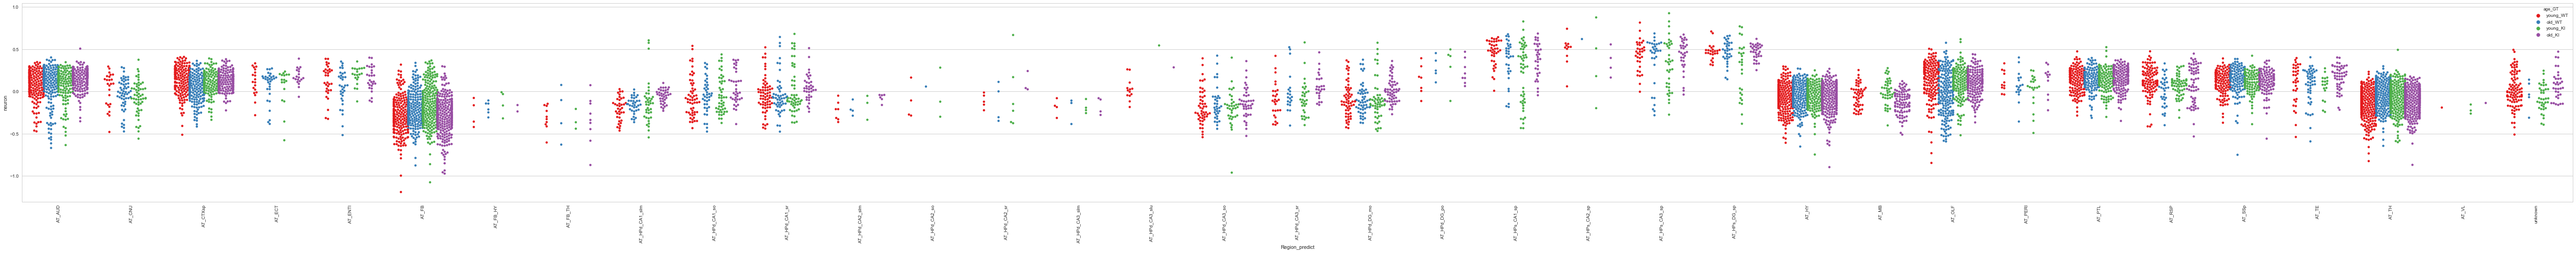

In [43]:
plot_dist_by_age_GT(meta_df, NEURON)